In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import  copy
import numpy as np

In [2]:
latent_dims = 2
num_epochs = 20
batch_size = 128
capacity = 64
learning_rate = 1e-3
#variational_beta = 0.05
variational_beta = 0.01
use_gpu = True



import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch import optim

img_transform = transforms.Compose([
    transforms.ToTensor()
])
mnist_trainset = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
                   batch_size=batch_size, shuffle=True)

mnist_testset = test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
                  batch_size=batch_size, shuffle=True)

In [3]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.fc_mu = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*7*7)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), capacity*2, 7, 7) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv1(x)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        return x



class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar

    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

def vae_loss(recon_x, x, mu, logvar,beta):

    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + variational_beta * kldivergence



vae = VariationalAutoencoder()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
vae = vae.to(device)

num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)
optimizer = optim.Adam(vae.parameters(), lr=7e-4)
rewind_state_dict = copy.deepcopy(vae.state_dict())



Number of parameters: 308357


/home/erik/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


## Pruning

In [4]:
from pruning import PruningConv2D, PruningLinear, PruningTool

#conv = nn.Conv2d(in_channels=4, out_channels=4, kernel_size=4, stride=2, padding=1)

#pr = PruningConv2D(conv)
#pr.set_mask_locally(0.3)
#for idx, channel in enumerate(conv.weight):
#    pr(conv,None)

#pr_stat = PruningTool()
#pr_stat.stats_pruning(conv)

## Training :

In [5]:
step = 0
plt_loss = []
prstat = PruningTool()
first_training = True
pruning_amount = np.linspace(0, 0.99,10)
final_pa = pruning_amount[-1]

number_epochs = 30

list_epochs = list(range(number_epochs))
list_global_sparsity = []
lists_training_loss = []
list_test_loss = []

for pa in pruning_amount:
    list_loss = []
    # local pruning
    for name,module in vae.named_modules():
        if isinstance(module, torch.nn.Linear):
            pr = PruningLinear(module)
            pr.set_mask_locally(pa)
            module.register_forward_pre_hook(pr)
        if isinstance(module, torch.nn.Conv2d):
            pr = PruningConv2D(module)
            pr.set_mask_locally(pa)
            module.register_forward_pre_hook(pr)

    for name, param in vae.named_parameters():
        param.data = rewind_state_dict[name].clone()

    for epoch in list_epochs:

        vae.train()
        train_loss = 0
        first_batch = True
        for batch_idx, (data, _) in enumerate(mnist_trainset):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = vae(data)

            if epoch ==0 and first_batch:
                list_global_sparsity.append(prstat.stats_pruning(vae,verbose=False))
                first_batch = False

            beta = 1
            loss = vae_loss(recon_batch, data, mu, logvar,beta)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            step += 1

            if  first_training and batch_idx == 500 :
                rewind_state_dict = copy.deepcopy(vae.state_dict())
                first_training = False
                print('rewind state saved')

        train_loss = train_loss / len(mnist_trainset.dataset)
        list_loss.append(train_loss)
        print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss))

    vae.eval()

    test_loss_avg, num_batches = 0, 0
    for image_batch, _ in mnist_testset:
        with torch.no_grad():
            image_batch = image_batch.to(device)
        # vae reconstruction
            image_batch_recon, latent_mu, latent_logvar = vae(image_batch)
        # reconstruction error
            loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar,beta)
            test_loss_avg += loss.item()
            num_batches += 1

    test_loss_avg /= len(mnist_testset.dataset)
    print('average reconstruction error: %f' % (test_loss_avg))

    list_test_loss.append(test_loss_avg)
    _, _, _ = vae(data)
    lists_training_loss.append(list_loss)

Sparsity in Layer encoder.conv1: 0.00%
Sparsity in Layer encoder.conv2: 0.00%
Linear(in_features=6272, out_features=2, bias=True)
Sparsity in Layer encoder.fc_mu: 0.01%
Linear(in_features=6272, out_features=2, bias=True)
Sparsity in Layer encoder.fc_logvar: 0.01%
Linear(in_features=2, out_features=6272, bias=True)
Sparsity in Layer decoder.fc: 0.01%
Global Sparsity : 0.00%
====> Epoch: 0 Average loss: 182.9821
====> Epoch: 1 Average loss: 164.1233
average reconstruction error: 161.603876
Sparsity in Layer encoder.conv1: 98.44%
Sparsity in Layer encoder.conv2: 98.44%
Linear(in_features=6272, out_features=2, bias=True)
Sparsity in Layer encoder.fc_mu: 99.00%
Linear(in_features=6272, out_features=2, bias=True)
Sparsity in Layer encoder.fc_logvar: 99.00%
Linear(in_features=2, out_features=6272, bias=True)
Sparsity in Layer decoder.fc: 99.00%
Global Sparsity : 98.56%
====> Epoch: 0 Average loss: 214.0767
====> Epoch: 1 Average loss: 206.2970
average reconstruction error: 206.215536


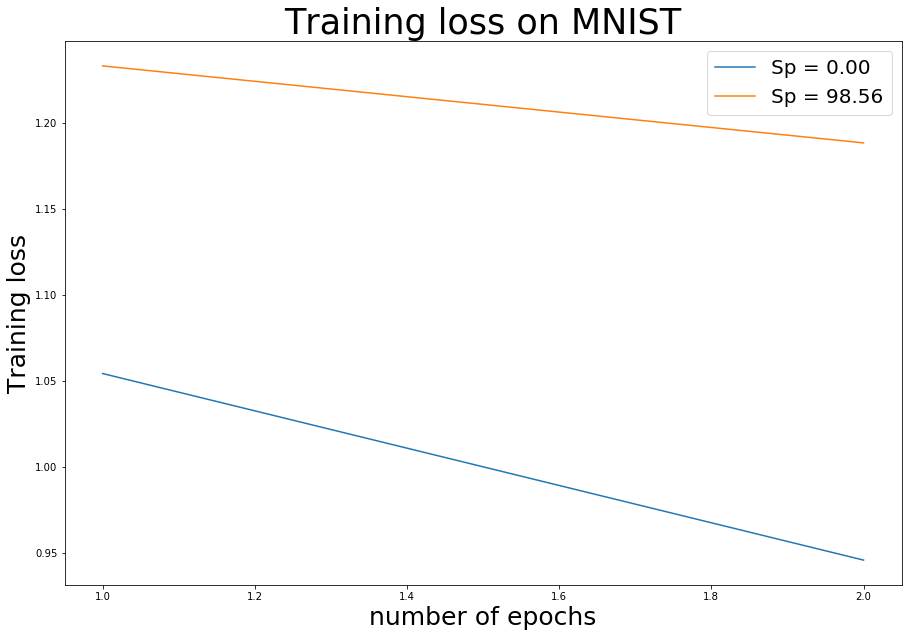

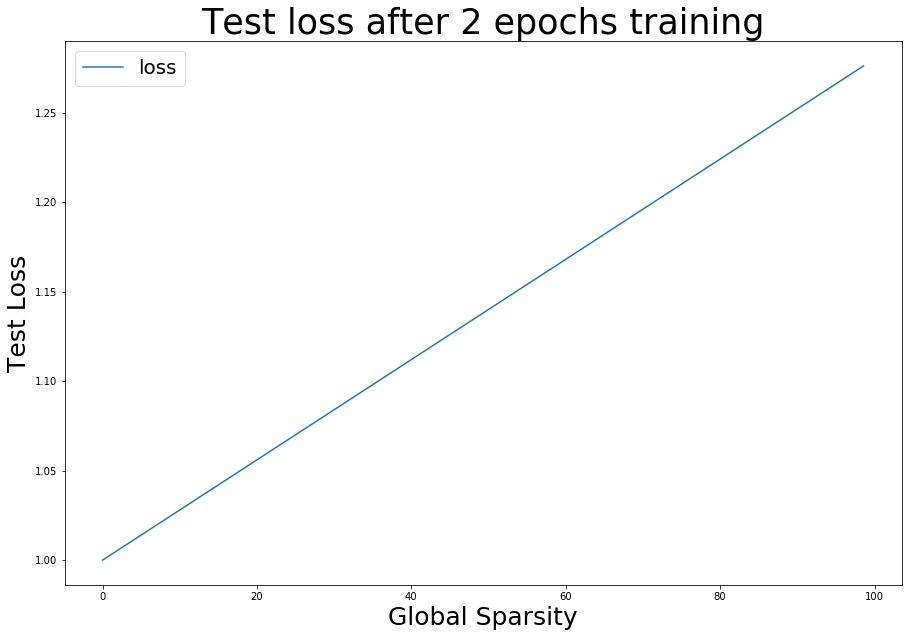

In [6]:
import matplotlib.pyplot as plt
from Visualizer import Visualizer


parameters = {'axes.labelsize': 25,
              'legend.fontsize': 20,
          'axes.titlesize': 35}
plt.rcParams.update(parameters)

v = Visualizer(list_global_sparsity, list_epochs, lists_training_loss, list_test_loss)

a = v.show_training_loss_pruning()
plt.show()
b = v.show_test_loss()
plt.show()